In [1]:
from ipynb.fs.full.GastricFunctions import *
#from BreastFunctions_py import *
import numpy as np
import pandas as pd

In [2]:
# Prepare this dataframe (total results) only once
total_results_dataframe = pd.DataFrame(columns=["Patient to be predicted/left out" , "Poor Survival Subpopulation" , "Moderate Survival Subpopulation" , 
"Good Survival Subpopulation", "Surv(months)" , "SAM Features for each tSNE run on new subset"])

# Only load if needed to load total results from previous runs to continue on
#total_results_dataframe = pd.read_csv("total_breastCancer_results.csv")


In [3]:
HE_image , MSI_data_cube , goodlist, peak_list, pixel_to_sample_ID, sample_only_data, sample_only_scaled_data , sample_ID_pixels = ReadGastricData()

In [4]:
## Selecting Patient as test
testPatient_ID = 1
#-------------------------------------------------------

train_scaled_data,train_data,train_ID_pixels,test_scaled_data,test_data,test_ID_pixels = SplitData(ID = testPatient_ID ,
        sample_only_data = sample_only_data,
        sample_only_scaled_data = sample_only_scaled_data,
        sample_ID_pixels = sample_ID_pixels )


In [ ]:
tsne_results = tSNE(train_scaled_data)
np.save("GastricCancer_tSNE_Model_Patient_{}".format(testPatient_ID) , tsne_results)

In [5]:
tsne_results = np.load("GastricCancer_tSNE_Model_Patient_{}.npy".format(testPatient_ID))

In [6]:
kmeans_3 , kmeans_4, kmeans_5, kmeans_6, kmeans_7, kmeans_8 = KMeans_results(tsne_results)

In [7]:
Clinical_data = ReadClinicalData(testPatient_ID , "ClinicalData.xlsx")
Clinical_data_full = pd.read_excel("ClinicalData.xlsx")

Clinical_data["Surv_time"] = Clinical_data["Surv_time"] / 30
Clinical_data_full["Surv_time"] = Clinical_data_full["Surv_time"] / 30

In [8]:
# Create dict to save kmeans results and select them later
kmeans_dict = { '3_Clusters' : kmeans_3.labels_ , '4_Clusters': kmeans_4.labels_ , '5_Clusters': kmeans_5.labels_ , '6_Clusters': kmeans_6.labels_ , '7_Clusters': kmeans_7.labels_ , '8_Clusters': kmeans_8.labels_ }
colors = [["red" , "green" , "yellow"],
          ["red" , "green" , "yellow" , "blue"],
          ["red" , "green" , "yellow" , "blue", "violet"],
          ["red" , "green" , "yellow" , "blue", "violet" , "Indigo"],
          ["red" , "green" , "yellow" , "blue", "violet" , "Indigo", "black"],
          ["red" , "green" , "yellow" , "blue", "violet" , "Indigo", "black", "purple"] ]

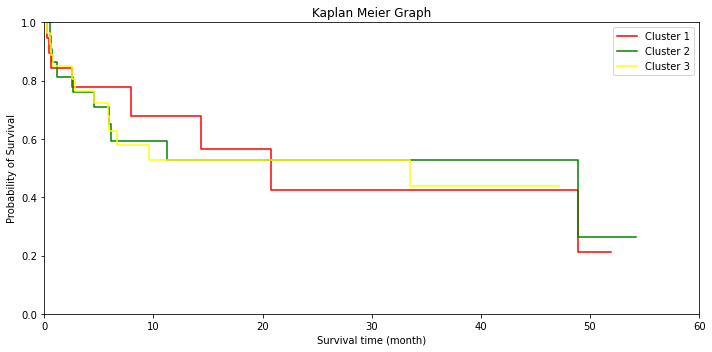

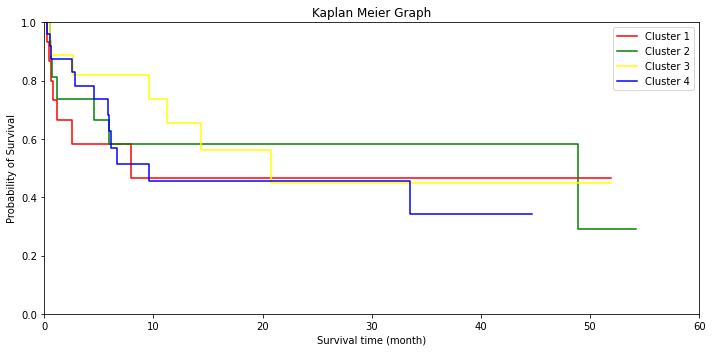

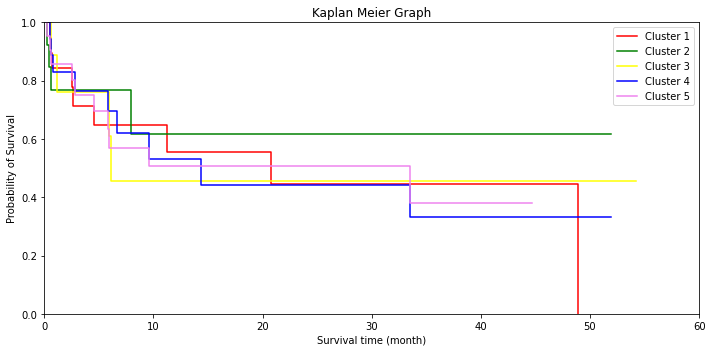

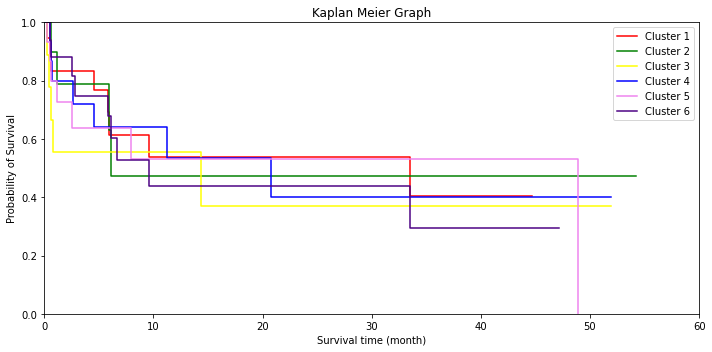

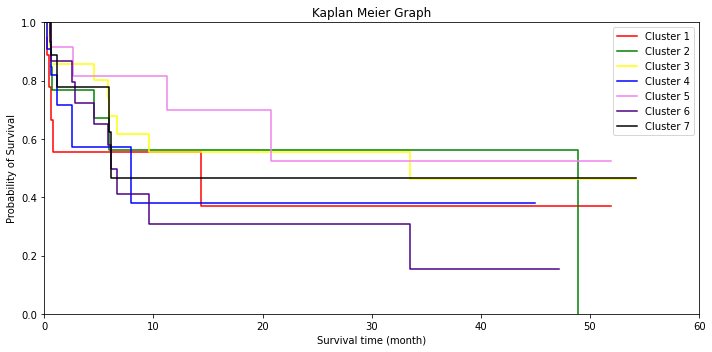

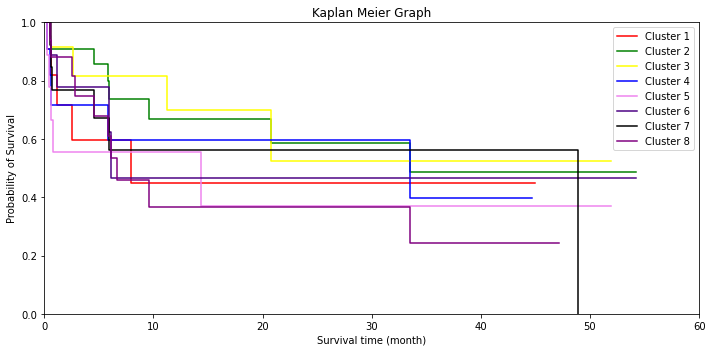

In [9]:
# Select the correct kmeans that shows best results from survival analysis, must have two completely seperetable survival lines
# KMeans at 3 clusters
for i in range(3,9):
    labels = kmeans_dict[str(i)+'_Clusters']
    Clinical_data_new = KaplanMeierSurvivalFitter(labels , colors = colors[i-3] , sample_ID_pixels = train_ID_pixels , Clinical_data = Clinical_data)

In [10]:
# Select the correct kmeans that shows best results from survival analysis, must have two completely seperetable survival lines
# 3 or 4 or 5 or 6 or 7 or 8 
selected_clusters_value = 7

# ----------------------------------------------------------------------------------

# Select the best kmeans
selected_state = kmeans_dict[str(selected_clusters_value) + "_Clusters"]
labels = kmeans_dict[str(selected_clusters_value) + "_Clusters"]

Clinical_data_new = KaplanMeierSurvivalFitter(labels , colors = colors[selected_clusters_value - 3], sample_ID_pixels = train_ID_pixels , Clinical_data = Clinical_data)
plt.close()

Results = LogRankTest_PrintValues(labels , Clinical_data_new, printResults=False)

labels_count = len(np.unique(labels))
pvalue_list =   [ [] for _ in range(labels_count) ]
min_pvalues = [ ]

for i in range(labels_count):
    for j in range(labels_count):
        if i == j:
            pass
        else:
            pvalue_list[i].append(round(Results[i][j].p_value,2))

for i in range(labels_count):
    min_pvalues.append(np.min(pvalue_list[i]))

SignCluster = [ ]
for i in range(len(min_pvalues)):
    if min_pvalues[i] == np.min(min_pvalues):
        SignCluster.append(i)

pvalue = np.min(min_pvalues)
print(SignCluster)


print("Significant Clusters are: Cluster " + str(SignCluster[0]+1) + " and Cluster " + str(SignCluster[1]+1))

[4, 5]
Significant Clusters are: Cluster 5 and Cluster 6


In [ ]:
# Check for signifiance between 2 clusters using cluster_value - 1 if needed
# Results[1][7]

Text(0.3, 0.05, 'P-value= 0.08')

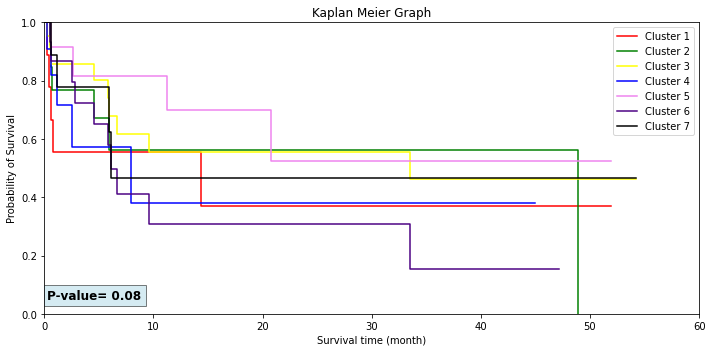

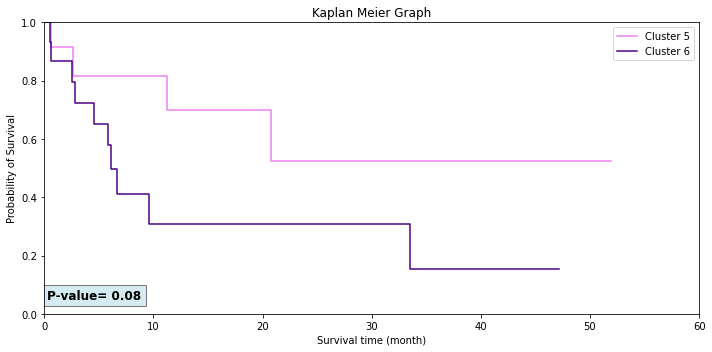

In [11]:
Clinical_data_new = KaplanMeierSurvivalFitter(labels , colors = colors[selected_clusters_value - 3], sample_ID_pixels = train_ID_pixels, Clinical_data = Clinical_data)
plt.text(0.30,0.05, "{}{}".format("P-value= ", pvalue) , fontsize = 12,fontweight="bold",bbox = dict(facecolor = 'lightblue', alpha = 0.5))

Clinical_data_new= KaplanMeierSurvivalFitter(labels , colors = colors[selected_clusters_value - 3], sample_ID_pixels = train_ID_pixels, Clinical_data = Clinical_data,SignCluster=SignCluster)
plt.text(0.30,0.05, "{}{}".format("P-value= ", pvalue) , fontsize = 12,fontweight="bold",bbox = dict(facecolor = 'lightblue', alpha = 0.5))

In [ ]:
cph = CoxHazardFitter(labels , Clinical_data = Clinical_data_new)

labels_count = len(np.unique(labels))

Clusters = [ [] for _ in range(labels_count)]
for cluster_label in range(labels_count):
    Clusters[cluster_label] = Clinical_data_new.query("Belong_Cluster_" + str(cluster_label+1) + " == 1")


In [ ]:
max_tick_value = 11.41 # increase this number till the colorbar shows correctly, take value from highest exp coeff (hazard ratio)
COLORS = ["yellow" , "red"]
CoxHazardBarPlot(cph = cph, colors = COLORS , max_tick_value = max_tick_value, clusters = Clusters)

In [12]:
# Using coxhazard to determine the significant clusters, check coxhazard before relying on these values
# hazardous_cluster_label = np.argmax(cph.hazard_ratios_) # Find the max hazard ratio's index and that will be the hazardous cluster label
# survival_cluster_label = np.argmin(cph.hazard_ratios_) # Find the min hazard ratio's index and that will be the highest survival cluster label

survival_cluster_label = 4
hazardous_cluster_label = 5

print("Hazardous cluster label's index is {} and it is cluster {}".format(hazardous_cluster_label,hazardous_cluster_label+1))

Hazardous cluster label's index is 5 and it is cluster 6


In [13]:
protein_dataframe = SAM_Analysis(labels, Clinical_data, train_ID_pixels, hazardous_cluster_label, train_data, peak_list)
protein_dataframe.to_csv("GastricCancerAverageSpectrumValues.csv",index=False)

# Run R file in order to generate significant proteins using the csv file

In [14]:
#Need to read significant protein file outputted from R

SAM_protein = readSignificantProteins("significant_gastric_proteins.json",delete=False)

SAM_protein_indices=[]
for i in range(len(peak_list)):

    if peak_list[i][0] in SAM_protein:
        SAM_protein_indices.append(i)

train_scaled_selected_proteins_data = train_scaled_data[:,SAM_protein_indices]
test_scaled_selected_proteins_data = test_scaled_data[:,SAM_protein_indices]

train_selected_proteins_data = train_data[:,SAM_protein_indices]
test_selected_proteins_data = test_data[:,SAM_protein_indices]

train_labels = TargetLabelsCreation(labels , Clinical_data, train_ID_pixels, hazardous_cluster_label , survival_cluster_label)

In [20]:
# Test rbf at c = 0.1 , 1 , 10
# Test linear at c = 0.1 , 1 , 10
y_pred_SVM = SVM("rbf" , 1 , train_scaled_data , train_labels , test_scaled_data)

In [21]:
Poor_Surv, Moderate_Surv , High_Surv = ProbabilityCalc(y_pred_SVM)
Surv_SVM = [Poor_Surv , Moderate_Surv, High_Surv]

Poor survival probability : 19.018802679922196 
Moderate survival probability : 73.04949211151934 
High survival probability : 7.931705208558461


In [22]:
y_pred_KNN = KNN(5 , train_scaled_data, train_labels, test_scaled_data)

In [23]:
Poor_Surv, Moderate_Surv , High_Surv  = ProbabilityCalc(y_pred_KNN)
Surv_KNN = [Poor_Surv , Moderate_Surv, High_Surv]

Poor survival probability : 16.209206829479143 
Moderate survival probability : 74.864923276421 
High survival probability : 8.925869894099849


In [24]:
# Selected Gastric probabilities, select KNN or SVM results
Selected_model = Surv_KNN
Poor_Surv = Selected_model[0]
Moderate_Surv = Selected_model[1]
High_Surv = Selected_model[2]

In [ ]:
# Run after model complete to save the result in the total results dataframe
total_results_dataframe = OutputDataframe(total_results_dataframe, testPatient_ID , Clinical_data_full, Poor_Surv , Moderate_Surv, High_Surv , SAM_protein)

In [ ]:
total_results_dataframe

In [ ]:
# Only run if needed to save and load at a later time
total_results_dataframe.to_csv("total_GastricCancer_results.csv" , index = False)